In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing  import StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf

In [2]:
RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE)

EPOCHS = 100 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 256

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.jet

plt.rcParams.update(params)

In [3]:
# Basic Hyper-parameter

inpDir = os.path.join('..','..','input')
outDir = os.path.join('..','output')
modelDir = os.path.join('..','models')
subDir = 'fifa 2019'

if not os.path.exists(outDir):
  os.makedirs(outDir)

if not os.path.exists(modelDir):
  os.makedirs(modelDir)

if not os.path.exists(os.path.join(modelDir, subDir)):
  os.makedirs(os.path.join(modelDir, subDir))

In [4]:
# for, Physical device :
physical_device = tf.config.list_physical_devices('GPU')
if len(physical_device) > 0:
  tf.config.experimental.set_memory_growth(physical_device[0], True)

In [5]:
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/fifa_2019.csv')
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [6]:
cols = data_df.columns

for col in cols:
  print(f'\n Column : {col} - {data_df[col].unique()}')


 Column : Unnamed: 0 - [    0     1     2 ... 18204 18205 18206]

 Column : ID - [158023  20801 190871 ... 241638 246268 246269]

 Column : Name - ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']

 Column : Age - [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]

 Column : Photo - ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']

 Column : Nationality - ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Swe

In [7]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [8]:
data_df = data_df[data_df['Position'].notnull()]
data_df.shape

(18147, 89)

In [9]:
rel_cols = ['Position','Finishing','HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
             'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
             'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
             'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
             'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
             'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
             'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [10]:
data_df.shape

(18147, 34)

In [11]:
data_df.isna().sum()

,0
Position,0
Finishing,0
HeadingAccuracy,0
ShortPassing,0
Volleys,0
Dribbling,0
Curve,0
FKAccuracy,0
LongPassing,0
BallControl,0


In [12]:
goalkeeper = 'GK'
forward = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW']
midfielders = ['CM', 'LCM',  'RCM', 'CDM', 'RDM' ,'LAM', 'CAM', 'RAM', 'LM', 'RM', 'LDM' ]
defenders = [ 'LWB', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

In [13]:
# Goal Keepers :
data_df.loc[data_df['Position'] == 'GK', 'Position'] =0

# Defenders :
data_df.loc[data_df['Position'].isin(defenders), 'Position'] = 1

# Mid - fielders :
data_df.loc[data_df['Position'].isin(midfielders), 'Position'] = 2

# Forward :
data_df.loc[data_df['Position'].isin(forward), 'Position'] = 3

# Prevent pandas from complaining
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast='integer')

In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 0 to 18206
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Position         18147 non-null  int8   
 1   Finishing        18147 non-null  float64
 2   HeadingAccuracy  18147 non-null  float64
 3   ShortPassing     18147 non-null  float64
 4   Volleys          18147 non-null  float64
 5   Dribbling        18147 non-null  float64
 6   Curve            18147 non-null  float64
 7   FKAccuracy       18147 non-null  float64
 8   LongPassing      18147 non-null  float64
 9   BallControl      18147 non-null  float64
 10  Acceleration     18147 non-null  float64
 11  SprintSpeed      18147 non-null  float64
 12  Agility          18147 non-null  float64
 13  Reactions        18147 non-null  float64
 14  Balance          18147 non-null  float64
 15  ShotPower        18147 non-null  float64
 16  Jumping          18147 non-null  float64
 17  Stamina          

In [15]:
labels = data_df['Position']
features_df = data_df.drop('Position', axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE)

X_train.shape,X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [17]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

y_train = y_train.to_numpy()

y_test = y_test.to_numpy()

### TensorFlow Datasets

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
type(train_ds)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [19]:
train_ds = train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)

test_ds = test_ds.shuffle(buffer_size=X_test.shape[0]).batch(BATCH_SIZE)

In [20]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Now we cant see the data head as the data here is in the form of batches, thus when we try to print we dont get the value of batch so we fetch the values by next iter

In [21]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 33), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int8, name=None))>

In [22]:
next(iter(train_ds))

(<tf.Tensor: shape=(256, 33), dtype=float64, numpy=
 array([[-1.40940648, -2.37242944, -2.22160236, ...,  2.2335296 ,
          2.50974981,  2.41343878],
        [ 1.04881658,  0.96385295, -1.27004689, ..., -0.19532294,
         -0.43407708, -0.03964503],
        [ 0.94639062, -1.16446513,  0.08931806, ..., -0.19532294,
         -0.66958323, -0.59716408],
        ...,
        [-0.74363774, -0.9918988 ,  0.97290528, ..., -0.62037214,
         -0.43407708, -0.20690075],
        [-0.89727668,  0.56119818,  0.4291593 , ..., -0.13460163,
         -0.25744747, -0.59716408],
        [ 0.9976036 ,  0.44615396,  0.90493703, ..., -0.25604426,
         -0.19857093, -0.59716408]])>,
 <tf.Tensor: shape=(256,), dtype=int8, numpy=
 array([0, 3, 2, 1, 2, 1, 2, 2, 2, 1, 1, 3, 3, 2, 0, 1, 0, 2, 2, 2, 0, 1,
        3, 3, 2, 3, 3, 3, 0, 2, 0, 2, 2, 1, 3, 3, 0, 2, 1, 1, 0, 0, 2, 3,
        2, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 0, 3, 2, 3, 1,
        2, 3, 0, 2, 1, 1, 2, 3, 2, 2, 1, 1, 1, 2, 2,

In [23]:
for features , labels in train_ds.take(1):
  print(features.shape, labels.shape)

(256, 33) (256,)


## Prepare model using Functional API

In [24]:
inp = tf.keras.Input(shape = (33,))

x = tf.keras.layers.Dense(18, activation=tf.nn.relu)(inp)

out = tf.keras.layers.Dense(4)(x)

model = tf.keras.Model(inputs = inp, outputs = out)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           612 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688 (2.69 KB)

 Trainable params: 688 (2.69 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Loss Function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

In [26]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [27]:
history = model.fit(train_ds, validation_data=test_ds, epochs = EPOCHS)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3980 - loss: 1.3184 - val_accuracy: 0.7292 - val_loss: 0.7906
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7575 - loss: 0.7219 - val_accuracy: 0.7978 - val_loss: 0.5505
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8066 - loss: 0.5272 - val_accuracy: 0.8132 - val_loss: 0.4608
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8217 - loss: 0.4503 - val_accuracy: 0.8245 - val_loss: 0.4195
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8336 - loss: 0.4119 - val_accuracy: 0.8328 - val_loss: 0.3946
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8421 - loss: 0.3879 - val_accuracy: 0.8408 - val_loss: 0.3766
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8481 - loss: 0.3705 - val_accuracy: 0.8441 - val_loss: 0.3627
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8544 - loss: 0.3569 - val_accuracy: 0.8501 - v

In [28]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.518013,1.105735,0.729201,0.790583
1,0.777433,0.654811,0.797796,0.550455
2,0.813047,0.497595,0.813223,0.460772
3,0.826962,0.432681,0.824518,0.419548
4,0.836881,0.398805,0.832782,0.394623


In [29]:
def fn_plot_tf_hist(hist_df):

    fig, axes = plt.subplots(1,2, figsize=(15,5))

    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    best = hist_df[hist_df[y4] == hist_df[y4].min()]
    # print(best)

    props = dict(boxstyle = 'round', facecolor = 'aqua', alpha = 0.4)
    facecolor = 'cyan'
    fontsize = 12
    CMAP = plt.cm.coolwarm
    ax = axes[0]

    hist_df.plot(y=[y2,y4], ax=ax, colormap = CMAP)
    txtFmt = 'Loss : \n   train : {:6.4f}\n     test : {:6.4f}'
    txtstr = txtFmt.format(hist_df.iloc[-1][y2].min(), hist_df.iloc[-1][y4])


    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', bbox = props)

    # Offset for the Arrows
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max - y_min)/10.0

    ax.annotate(f'Min : {best[y4].to_numpy()[0]:6.4}',    # text to print
                xy = (best.index.to_numpy()[0], best[y4].to_numpy()[0]),  # start
                xytext = (best.index.to_numpy()[0], best[y4].to_numpy()[0] + offset),   #end
                fontsize = fontsize, va='bottom', ha = 'right', bbox= props,
                arrowprops = dict(facecolor = facecolor, shrink = 0.05))

    ax.axvline(best.index.to_numpy()[0], color = 'g', linestyle = '-.', lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())

    ax.grid()


    ax = axes[1]
    hist_df.plot(y=[y1,y3], ax=ax, colormap = CMAP)
    txtFmt = 'Loss : \n   train : {:6.4f}\n     test : {:6.4f}'
    txtstr = txtFmt.format(hist_df.iloc[-1][y1], hist_df.iloc[-1][y3])

    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', bbox = props)

    # Offset for the Arrows
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max - y_min)/10.0

    ax.annotate(f'Best : {best[y3].to_numpy()[0]:6.4}',    # text to print
                xy = (best.index.to_numpy(), best[y3].to_numpy()[0]),  # start
                xytext = (best.index.to_numpy(), best[y3].to_numpy()[0] + offset),
                fontsize = fontsize, va='bottom', ha = 'right', bbox= props,
                arrowprops = dict(facecolor = facecolor, shrink = 0.05))

    ax.axvline(best.index.to_numpy(), color = 'g', linestyle = '-.', lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y1.capitalize())

    ax.grid()
    plt.suptitle('Training Perfromance')
    plt.tight_layout()
    plt.show()
    # ax = axes[1]
    # hist_df.plot(y=[y2,y4], ax=axes[0])
    # hist_df.plot(y=[y1,y3], ax=ax)

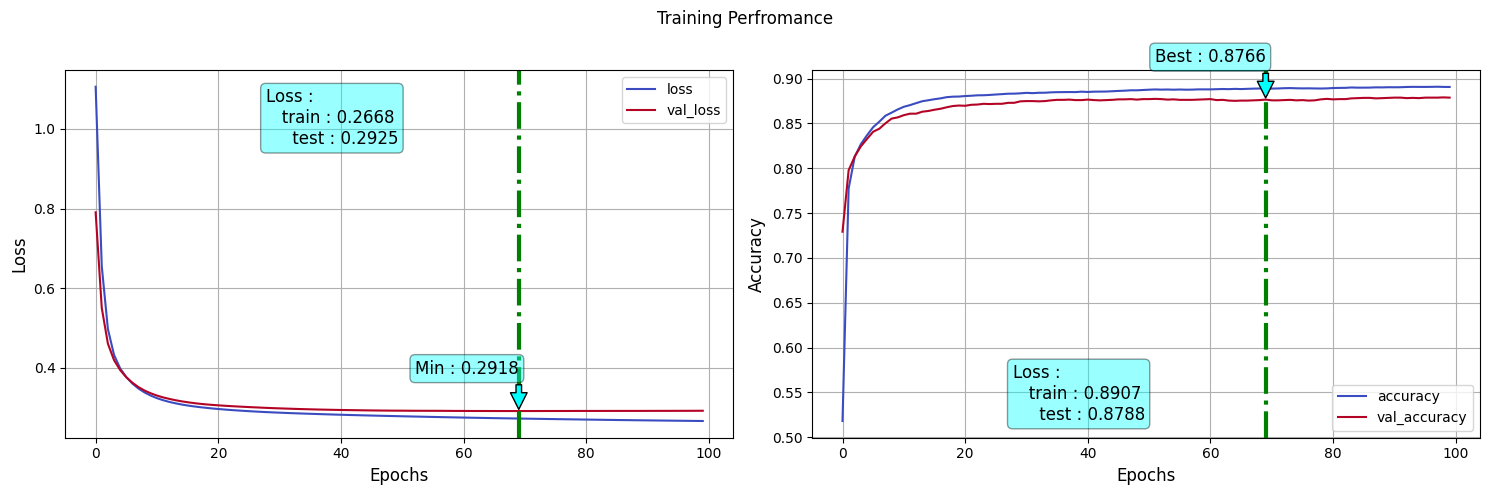

In [30]:
fn_plot_tf_hist(loss_df)

In [31]:
prob_model = tf.keras.Sequential(
    [model,
     tf.keras.layers.Softmax()]
)
prob_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 4)              │           688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688 (2.69 KB)

 Trainable params: 688 (2.69 KB)

 Non-trainable params: 0 (0.00 B)

### Train Predictions

In [32]:
y_true, y_pred = [], []

for feats, lbls in train_ds:
    pred = prob_model(feats)
    y_pred.extend(pred.numpy().argmax(axis=1))
    y_true.extend(lbls)

len(y_true), len(y_pred)

(14517, 14517)

In [33]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.93      0.93      4693
           2       0.84      0.88      0.86      5470
           3       0.86      0.79      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



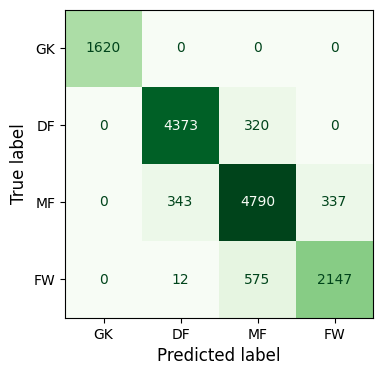

In [34]:
display_labels = ['GK','DF','MF','FW']

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Greens', colorbar=False)